In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
matplotlib.rcParams['font.family'] = 'serif'
import os
import glob
__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

In [2]:
def read_paramdict(majorlabel, minorlabel='', sort='astero'):
    '''Reads in results for either:
        -A full run series (majorlabel) where the minorlabel is included as a
            column in the output.
        -A single run (majorlabel and minorlabel).

        Returns a pandas dataframe.
    '''
    loc = __outdir__+majorlabel+'/'

    if minorlabel != '':
        globlist = glob.glob(loc+sort+'_'+str(float(minorlabel))+'_*pars*.csv')
    else:
        globlist = glob.glob(loc+sort+'*_*pars*.csv')

    minorlabels = [os.path.basename(globloc).split('_')[1] for globloc in globlist]

    df = pd.DataFrame()
    for n, globloc in enumerate(globlist):
        sdf = pd.read_csv(globloc, index_col = 0)
        if minorlabels[n] != 'pars.csv':
            sdf[majorlabel] = minorlabels[n]
        df = df.append(sdf)

    return df.sort_values(by=majorlabel)

### Lets read in the data, and generate a cov matrix

In [3]:
from sklearn.utils import shuffle
kdf = pd.read_csv('/home/oliver/PhD/Gaia_Project/data/KepxDR2/rcxyu18.csv')
kdf = shuffle(kdf, random_state=24601).reset_index(drop=True)

Targets in our dataframe: 100


/home/oliver/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


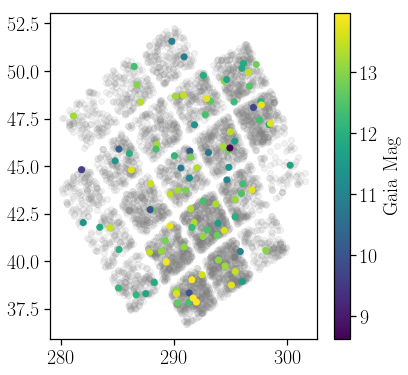

In [4]:
df = kdf[:100]
print('Targets in our dataframe: '+str(len(df)))
f,a = plt.subplots(figsize=(6,6))
a.scatter(kdf.ra, kdf.dec, c = 'grey', alpha=.1)
c = a.scatter(df.ra, df.dec, c=df.GAIAmag, cmap='viridis')
f.colorbar(c, label=r"Gaia Mag")
plt.show()

In [5]:
def kernel(ra, dec, sigma, p):
    '''
    p[0] : Offset
    p[1] : Exponential decay scale
    '''
    thetaij = np.sqrt(np.subtract.outer(ra, ra)**2 + np.subtract.outer(dec, dec)**2)
    cov = p[0] * np.exp(-thetaij / p[1])
    np.fill_diagonal(cov, np.diag(cov) + sigma**2)
    return cov

In [6]:
p = [285.0*10**-6, 14.]
Sigma = kernel(df.ra.values, df.dec.values, df.parallax_error.values, p)
invc = np.linalg.inv(Sigma)
logdetc = np.linalg.slogdet(Sigma)[1] * np.linalg.slogdet(Sigma)[0]

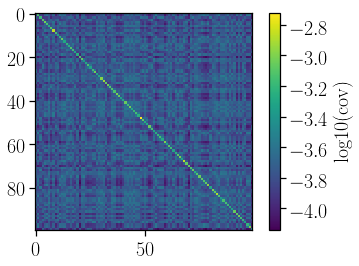

In [7]:
c = plt.imshow(np.log10(Sigma))
plt.colorbar(c, label='log10(cov)')
plt.show()
if not np.all(np.linalg.eigvals(Sigma) > 0):
    raise ValueError("The matrix isn't positive-definite for some reason!")

### Lets do a quick run to get Bailer-Jones distances only (with covariance)

In [8]:
import pystan
regular = '''
functions {
    real bailerjones_lpdf(real r, real L){             //This is our distance prior
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
    real precalc_multinormal_lpdf(vector oo, vector oo_true, real logdetc, matrix invc, int N, real Nfloat){
        vector[N] r;       
        r = oo - oo_true;

        return -0.5 * ((r' * invc * r) + logdetc + Nfloat * log(2*pi()));
    }
}
data {
    int<lower = 0> N;
    real<lower=0> Nfloat;
    vector[N] oo;
    real L[N];
    
    real logdetc;
    matrix[N, N] invc;
}
parameters {
    real<lower = 1.> ri[N];                            //Can't have something being closer than 1 parsec!
}
transformed parameters {
    vector[N] ootrue;
    for (n in 1:N){
        ootrue[n] = (1000./ri[n] - 0.029);
    }
}
model {
    for (n in 1:N){
        ri[n] ~ bailerjones(L[n]);
    }
    oo ~ precalc_multinormal(ootrue, logdetc, invc, N, Nfloat);      
}
'''
sm = pystan.StanModel(model_code = regular)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_27d10f8af8c2490412191159b5be3745 NOW.


In [9]:
dat = { 'N': len(df),
        'Nfloat': np.float(len(df)),
        'oo' : df.parallax.values,       #Observed parallax
        'L': df.r_length_prior.values,
        'logdetc' : logdetc,
        'invc' : invc} 
regular_fit = sm.sampling(data=dat, iter=5000, seed=24601, chains=4)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


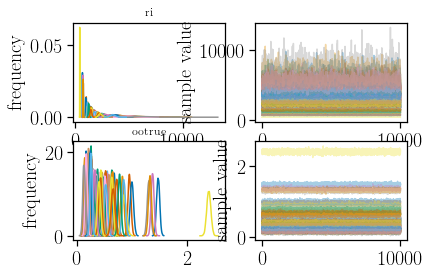

In [10]:
regular_fit.plot()
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


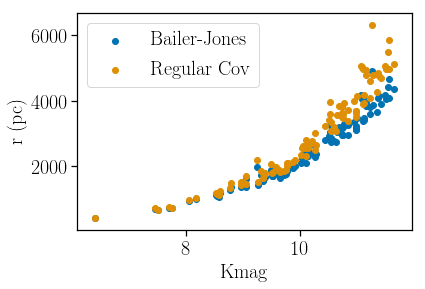

In [11]:
regular_ri = np.median(regular_fit['ri'], axis=0)
fig, ax = plt.subplots()
ax.scatter(df.kmag, df.r_est, label='Bailer-Jones')
ax.scatter(df.kmag, regular_ri, label='Regular Cov')
ax.set_xlabel('Kmag')
ax.set_ylabel('r (pc)')
ax.legend(loc='best', fontsize=20)
plt.show()

### Now lets do a *full run* using all the photometric input!

In [12]:
astrostan = '''
functions {
    real bailerjones_lpdf(real r, real L){
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
    real precalc_multinormal_lpdf(vector oo, vector oo_true, real logdetc, matrix invc, int N, real Nfloat){
        vector[N] r;       
        r = oo - oo_true;

        return -0.5 * ((r' * invc * r) + logdetc + Nfloat * log(2*pi()));
    }    
}
data {
    int<lower = 0> N;
    real<lower= 0> Nfloat;
    vector[N] m;
    vector<lower=0>[N] m_err;
    vector[N] oo;
    vector<lower=0>[N] RlEbv;

    matrix[N, N] invc;
    real logdetc;

    real mu_init;
    real mu_spread;
    
}
parameters {
    //Hyperparameters
    real mu;
    real<lower=0.> sigma;
    real<lower=1.> sigo;
    real<lower=0.5,upper=1.> Q;
    real<lower=.1, upper=4000.> L;
    real oo_zp;

    //Latent parameters
    vector[N] M_infd_std;
    vector[N] Ai;
    vector<lower = 1.>[N] r_infd;
}
transformed parameters{
    //Inferred and transformed parameters
    vector[N] M_infd;

    //Operations
    for (n in 1:N){
        M_infd[n] = mu + sigma * M_infd_std[n]; //Rescale the M fit
    }
}
model {
    //Define calculable properties
    vector[N] m_true;
    vector[N] oo_true;

    //Hyperparameters [p(theta_rc, L)]
    mu ~ normal(mu_init, mu_spread); // Prior from seismo
    sigma ~ normal(0., 1.);
    Q ~ normal(1., .25);
    sigo ~ normal(3.0, 1.0);
    L ~ uniform(0.1, 4000.);   // Prior on the length scale
    oo_zp ~ normal(0.0, 500.); // Prior on the offset (in mu as)

    //Latent parameters [p(alpha_i | theta_rc, L)]
    Ai ~ normal(RlEbv, 0.05);
    for (n in 1:N){
        r_infd[n] ~ bailerjones(L);
        target += log_mix(Q,
            normal_lpdf(M_infd_std[n] | 0., 1.),
            normal_lpdf(M_infd_std[n] | 0., sigo));
    }

    //Calculable properties
    for (n in 1:N){
        m_true[n] = M_infd[n] + 5*log10(r_infd[n]) - 5 + Ai[n];
        oo_true[n] = (1000./r_infd[n]) + (oo_zp/1000.);
    }

    //Observables [p(D | theta_rc, L, alpha)]
    oo ~ precalc_multinormal(oo_true, logdetc, invc, N, Nfloat);      
    m ~ normal(m_true, m_err); //Measurement uncertainty on magnitude
}

'''
sm_full = pystan.StanModel(model_code = astrostan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_46babd58279c9401bc9f86edae70ff1c NOW.


In [13]:
tempdiff = -50.0

rlebv = df.Aks.values
mband = df.Kmag.values
merr = df.e_Kmag.values

astres = read_paramdict('APOKASC_K_tempscale_Clump', str(tempdiff), 'astero')

In [14]:
dat = {'N':len(df),
       'Nfloat':np.float(len(df)),
        'm': mband,
        'm_err': merr,
        'oo': df.parallax.values,
        'RlEbv': rlebv,
        'logdetc': logdetc,
        'invc': invc,
        'mu_init': astres['mu'].values[0],
        'mu_spread': astres['mu_std'].values[0]}

init= {'mu': astres.mu.values[0],
        'sigma': astres.sigma.values[0],
        'Q': astres.Q.values[0],
        'sigo': astres.sigo.values[0],
        'L': 1000.,
        'oo_zp':-29.}

In [15]:
full_fit = sm_full.sampling(data=dat, iter=5000, chains=4, seed=24601, init=[init for i in range(4)])

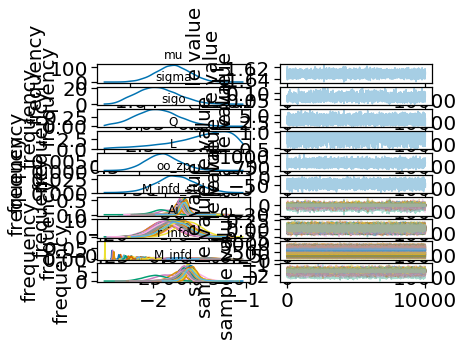

In [16]:
matplotlib.rcParams['text.usetex']=False
full_fit.plot()
plt.show()
matplotlib.rcParams['text.usetex']=True

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


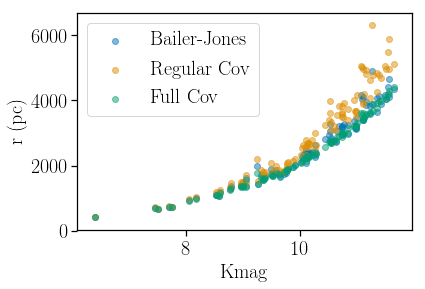

In [17]:
full_ri = np.median(full_fit['r_infd'], axis=0)
fig, ax = plt.subplots()
ax.scatter(df.kmag, df.r_est,alpha=.5, label='Bailer-Jones')
ax.scatter(df.kmag, regular_ri,alpha=.5, label='Regular Cov')
ax.scatter(df.kmag, full_ri,alpha=.5, label='Full Cov')
ax.set_xlabel('Kmag')
ax.set_ylabel('r (pc)')
ax.legend(loc='best', fontsize=20)
plt.show()

#### Lets have a look at the other diagnostic plots for the run...

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


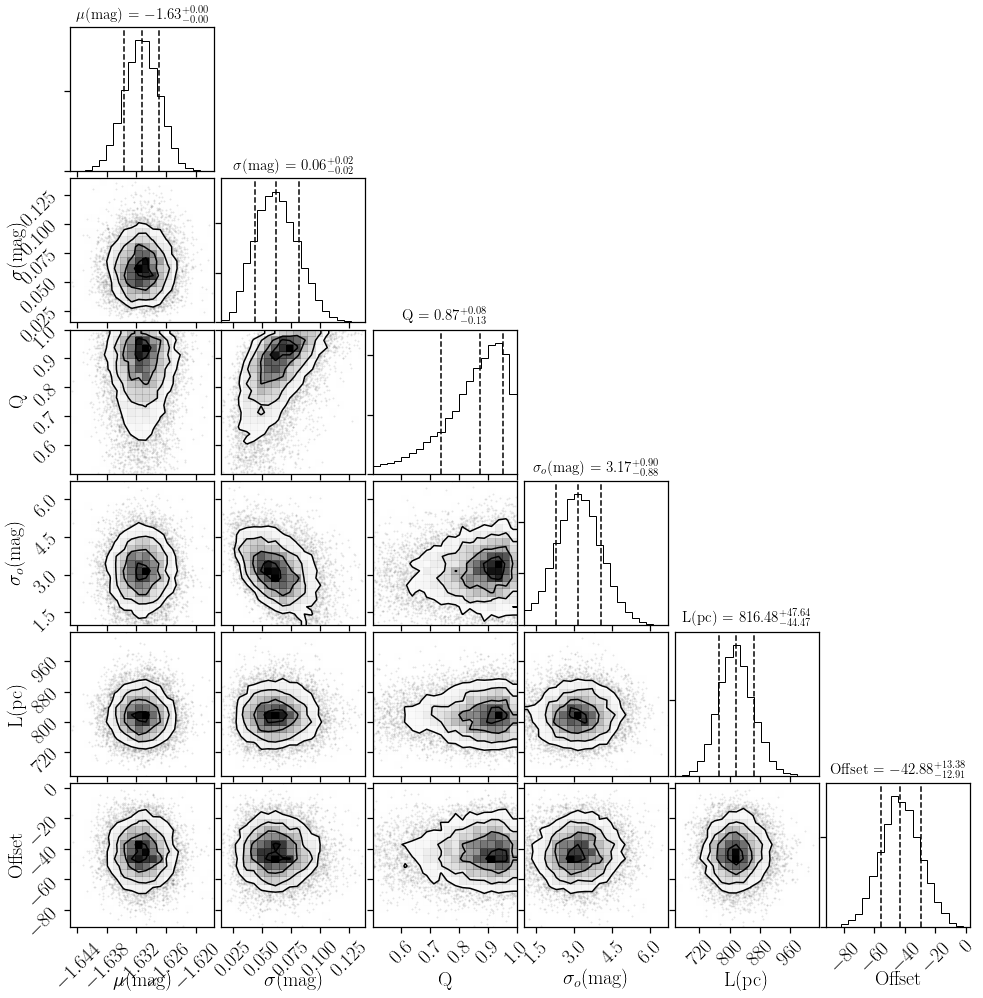

In [18]:
import corner
chain = np.array([full_fit['mu'],full_fit['sigma'],full_fit['Q'],full_fit['sigo'],full_fit['L'], full_fit['oo_zp']])
corner.corner(chain.T,\
                labels=[r'$\mu$(mag)',r'$\sigma$(mag)','Q',r'$\sigma_o$(mag)','L(pc)', 'Offset'],\
                quantiles=[0.16, 0.5, 0.84],\
                show_titles=True, title_kwargs={"fontsize": 15})
plt.show()

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


Total number of Rhats: 407
Total number of Rhats with the NaN values removed: 407
Total number of Rhats over 1.01: 0
Total number of Rhats over 1.1: 0


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


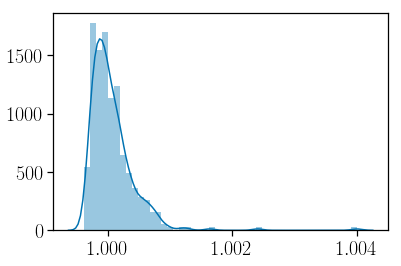

In [19]:
s = full_fit.summary()
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
print('Total number of Rhats over 1.01: '+str(len(rhat[rhat > 1.01])))
print('Total number of Rhats over 1.1: '+str(len(rhat[rhat > 1.1])))
sns.distplot(rhatfin)
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


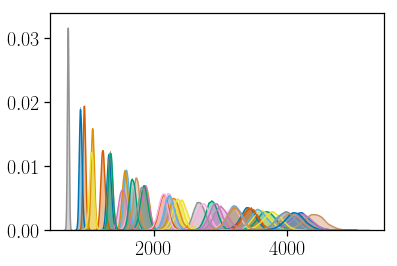

In [20]:
for i in range(50):
    sns.distplot(full_fit['r_infd'][:,i])